In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram as scipy_dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [16]:
class AgglomerativeClustering:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.clusters = []
        self.merges = []
        self.distances = []
    
    def makeClusters(self, data):
        self.clusters = [{i} for i in range(len(data))]
        self.data = data

        while len(self.clusters) > self.n_clusters:
            cluster1_idx, cluster2_idx = self.findClosestPair()
            self.mergeClusters(cluster1_idx, cluster2_idx)
        return self.clusters
    
    def euclideanDist(self, cluster1, cluster2):
        min_dist = np.inf
        for i in cluster1:
            for j in cluster2:
                dist = np.linalg.norm(self.data[i] - self.data[j])
                if dist < min_dist:
                    min_dist = dist
        return min_dist
    
    def findClosestPair(self):
        min_dist = np.inf
        closest_pair = None

        for i in range(len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                dist = self.euclideanDist(self.clusters[i], self.clusters[j])
                if dist < min_dist:
                    min_dist = dist
                    closest_pair = (i, j)
        
        return closest_pair
    
    def mergeClusters(self, cluster1id, cluster2id):
        new_cluster = self.clusters[cluster1id].union(self.clusters[cluster2id])
        self.merges.append((cluster1id, cluster2id))
        self.distances.append(self.euclideanDist(self.clusters[cluster1id], self.clusters[cluster2id]))
        self.clusters.pop(max(cluster1id, cluster2id))
        self.clusters.pop(min(cluster1id, cluster2id))
        self.clusters.append(new_cluster)
    
    


In [17]:
class DivisiveClustering:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.clusters = []
        self.merges = []
        self.distances = []
    
    def makeClusters(self, data):
        self.clusters = [set(range(len(data)))]
        self.data = data

        while len(self.clusters) < self.n_clusters:
            cluster_idx = self.findClusterToDivide()
            if cluster_idx is not None:
                self.divideClusters(cluster_idx)
            else:
                break
        return self.clusters
    
    def findFurthestPair(self, cluster_points):
        max_dist = 0
        furthest_pair = None
        for i in cluster_points:
            for j in cluster_points:
                if i != j:
                    dist = np.linalg.norm(self.data[i] - self.data[j])
                    if dist > max_dist:
                        max_dist = dist
                        furthest_pair = (i, j)
        return furthest_pair
    
    def euclideanDist(self, point1, point2):
        return np.linalg.norm(self.data[point1] - self.data[point2])
    
    def findClusterToDivide(self):
        max_size = 0
        cluster_idx = None
        for idx, cluster in enumerate(self.clusters):
            if len(cluster) > 1 and len(cluster) > max_size:
                max_size = len(cluster)
                cluster_idx = idx
        return cluster_idx

    def divideClusters(self, cluster_idx):
        cluster_points = list(self.clusters[cluster_idx])
        furthest_pair = self.findFurthestPair(cluster_points)
        if furthest_pair is None:
            return

        point_a, point_b = furthest_pair
        new_cluster_1 = set()
        new_cluster_2 = set()
        
        for point in cluster_points:
            if self.euclideanDist(point, point_a) < self.euclideanDist(point, point_b):
                new_cluster_1.add(point)
            else:
                new_cluster_2.add(point)
        
        self.clusters.pop(cluster_idx)
        self.clusters.append(new_cluster_1)
        self.clusters.append(new_cluster_2)

In [18]:
x_data = np.random.ranf(10)
y_data = np.random.ranf(10)

In [19]:
dots_tuple = np.transpose((x_data,y_data))

In [20]:
aggl_cluster = AgglomerativeClustering(2)
aggl_cluster.makeClusters(dots_tuple)

[{9}, {0, 1, 2, 3, 4, 5, 6, 7, 8}]

In [21]:
divis_cluster = DivisiveClustering(3)
divis_cluster.makeClusters(dots_tuple)

[{1, 2, 5, 6, 8}, {0, 3, 4, 7}, {9}]

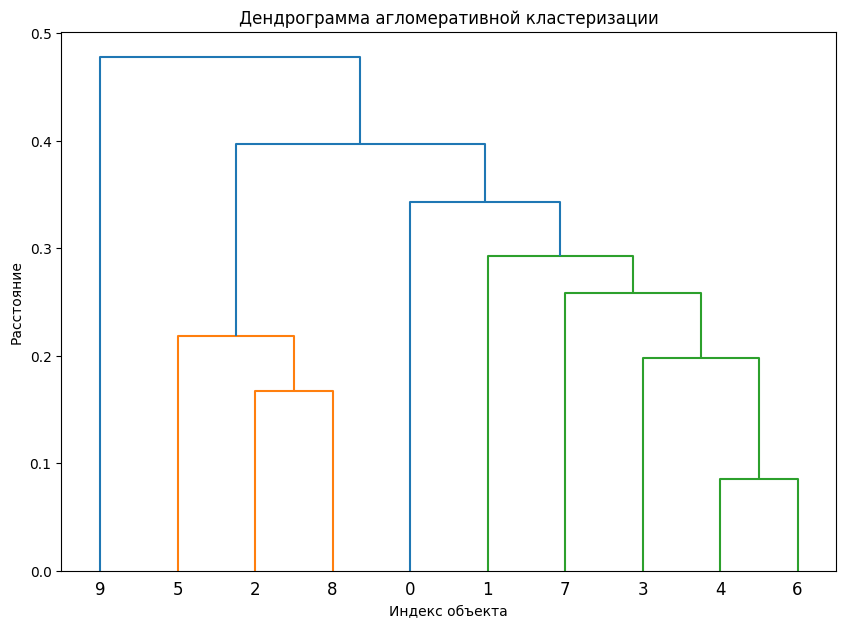

In [22]:
distance_matrix = sch.distance.pdist(dots_tuple)

# Построение иерархической кластеризации
linkage_matrix = sch.linkage(distance_matrix)

# Построение дендрограммы
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс объекта')
plt.ylabel('Расстояние')
plt.show()

In [23]:
def evaluate_clustering(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    def compactness(data, labels):
        cluster_ids = np.unique(labels)
        compactness_values = []
        for cluster_id in cluster_ids:
            cluster_data = data[labels == cluster_id]
            if len(cluster_data) > 1:
                dist_matrix = squareform(pdist(cluster_data))
                intra_dist = np.sum(dist_matrix) / (2 * len(cluster_data))
                compactness_values.append(intra_dist)
        return np.mean(compactness_values)
    compactness_avg = compactness(data, labels)

    def separability(data, labels):
        cluster_ids = np.unique(labels)
        centers = np.array([data[labels == cluster_id].mean(axis=0) for cluster_id in cluster_ids])
        if len(centers) > 1:
            inter_dist_matrix = pdist(centers)
            separability_value = np.min(inter_dist_matrix)
            return separability_value
        return 0
    
    separability_value = separability(data, labels)

    return silhouette_avg, compactness_avg, separability_value



In [24]:
aggl_labels = np.zeros(len(dots_tuple))
for idx, cluster in enumerate(aggl_cluster.clusters):
    for point in cluster:
        aggl_labels[point] = idx

aggl_metrics = evaluate_clustering(dots_tuple, aggl_labels)

In [25]:
divis_labels = np.zeros(len(dots_tuple))
for idx, cluster in enumerate(divis_cluster.clusters):
    for point in cluster:
        divis_labels[point] = idx

divis_metrics = evaluate_clustering(dots_tuple, divis_labels)

In [26]:
print("Агломеративная кластеризация:")
print(f"Силуэт: {aggl_metrics[0]}")
print(f"Компактность (C): {aggl_metrics[1]}")
print(f"Отделимость (D): {aggl_metrics[2]}")

Агломеративная кластеризация:
Silhouette Coefficient: 0.2916482066922945
Compactness (C): 2.01200753387258
Separability (D): 0.7023249255592525


In [27]:
print("\nДивизионная кластеризация:")
print(f"Силуэт: {divis_metrics[0]}")
print(f"Компактность (C): {divis_metrics[1]}")
print(f"Отделимость (D): {divis_metrics[2]}")


Дивизионная кластеризация:
Silhouette Coefficient: 0.27908496212613343
Compactness (C): 0.6527491077150761
Separability (D): 0.5495509931321305
